# Starbucks Capstone Challenge Cleaning

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie f
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
%pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2021-10-25 19:58:04 +08:00)


In [2]:
import pandas as pd
import numpy as np
import math
import json
from functools import reduce
from datetime import date
from dateutil.parser import parse
import re

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json.zip', orient='records', lines=True)

time: 2.11 s (started: 2021-10-25 19:58:04 +08:00)


In [3]:
def show_desc(df:pd.DataFrame)->pd.DataFrame:
    """show some aggregate of a pd.DataFrame"""
    desc = pd.DataFrame([df.isnull().sum(),df.isnull().mean(),df.dtypes,df.count(),df.nunique(),df.min(),df.max(),df.median()],
             index=['null_count','null_ratio','dtypes','value_count','uique_counts','value_min','value_max','value_median'])\
    .sort_values(by=['null_ratio','uique_counts'],axis=1,ascending=[False,True])
    return desc

time: 0 ns (started: 2021-10-25 19:58:06 +08:00)


# Clean portfolio

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


time: 31 ms (started: 2021-10-25 19:58:06 +08:00)


extract all the channels

In [5]:
channels_words = portfolio['channels'].to_list()
channels_words

[['email', 'mobile', 'social'],
 ['web', 'email', 'mobile', 'social'],
 ['web', 'email', 'mobile'],
 ['web', 'email', 'mobile'],
 ['web', 'email'],
 ['web', 'email', 'mobile', 'social'],
 ['web', 'email', 'mobile', 'social'],
 ['email', 'mobile', 'social'],
 ['web', 'email', 'mobile', 'social'],
 ['web', 'email', 'mobile']]

time: 0 ns (started: 2021-10-25 19:58:06 +08:00)


In [6]:
from functools import reduce

all_words = reduce(lambda x,y:set(x).union(set(y)), channels_words)
all_words

{'email', 'mobile', 'social', 'web'}

time: 0 ns (started: 2021-10-25 19:58:06 +08:00)


In [7]:
def parse_channel(x:list,attr_matrix:list=['email', 'mobile', 'social', 'web'])->list:
    """check whether list x has attributes of attr_matrix, mark 1 if has else 0.

    To use:
     >>> s = parse_channel(['email', 'mobile', 'social'])
     >>> s
     [1,1,1,0]
     
    Args:
        x: a list of string.
        attr_matrix: a list of string as basic attributes
    
    Returns:
        x_parsed: a list of string
    """
    
    x_parsed = np.isin(attr_matrix,x)
    x_parsed = [1 if p else 0  for p in x_parsed ]
    
    return x_parsed

time: 0 ns (started: 2021-10-25 19:58:06 +08:00)


In [8]:
portfolio[['channel_email', 'channel_mobile', 'channel_social', 'channel_web']]=pd.DataFrame(portfolio.apply(lambda x:parse_channel(x['channels']),axis=1).to_list(),index=portfolio.index)


time: 0 ns (started: 2021-10-25 19:58:06 +08:00)


In [9]:
# transfer `offer_type` into dummoy columns
offer_type_dummy = pd.get_dummies(portfolio['offer_type'],prefix='type')
portfolio = portfolio.merge(offer_type_dummy,left_index=True,right_index=True)


time: 0 ns (started: 2021-10-25 19:58:06 +08:00)


In [10]:
portfolio['id'].astype('category').cat.codes

0    7
1    4
2    3
3    6
4    0
5    1
6    9
7    5
8    8
9    2
dtype: int8

time: 0 ns (started: 2021-10-25 19:58:06 +08:00)


In [11]:
# transfer `offer_id` into code
portfolio['offer_code'] = portfolio['id'].map(lambda x:x[-3:])

time: 0 ns (started: 2021-10-25 19:58:06 +08:00)


In [12]:
# add a column `return` to compute the return of each offer, 0.0001 to avoid `divided by zero`
portfolio['return'] = portfolio.apply(lambda x:x['reward']/(x['difficulty']+0.0001),axis=1)

time: 0 ns (started: 2021-10-25 19:58:06 +08:00)


In [13]:
# drop some parsed columns
portfolio_clean = portfolio.drop(['channels'],axis=1)
portfolio_clean

,reward,difficulty,duration,offer_type,id,channel_email,channel_mobile,channel_social,channel_web,type_bogo,type_discount,type_informational,offer_code,return
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,dfd,0.999990
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,da0,0.999990
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,bed,0.000000
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0,6d9,0.999980
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,1d7,0.249999
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,8c2,0.428565
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,2a4,0.199998
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1,837,0.000000
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,20d,0.999980
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0,aa5,0.199998


time: 15 ms (started: 2021-10-25 19:58:06 +08:00)


In [14]:
# save clean results
portfolio_clean.to_csv('portfolio_clean.csv')

time: 0 ns (started: 2021-10-25 19:58:07 +08:00)


# Clean transcript

In [15]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


time: 16 ms (started: 2021-10-25 19:58:07 +08:00)


## value
clean `value` column to extract keys and values

In [16]:
transcript['keys'] = transcript['value'].map(lambda x:tuple(x.keys()))

time: 156 ms (started: 2021-10-25 19:58:07 +08:00)


In [17]:
transcript['keys'].value_counts()

(amount,)             138953
(offer id,)           134002
(offer_id, reward)     33579
Name: keys, dtype: int64

time: 47 ms (started: 2021-10-25 19:58:07 +08:00)


In [18]:
np.count_nonzero(transcript['keys'].isna())

0

time: 15 ms (started: 2021-10-25 19:58:07 +08:00)


the `value` columns has 3 types of info [amount,offer_id,reward]

In [19]:
def parse_value(x:dict)->list:
    """parse dict x to get all the values of [amount,offer_id,reward]
    
    Args:
        x: a dict
    
    Returns:
        parsed: list of str
    """
    amount = x.get('amount')
    offer_id = x.get('offer id')
    if not offer_id:
        offer_id = x.get('offer_id')
    reward = x.get('reward')
    parsed = [amount,offer_id,reward]
    return parsed

time: 0 ns (started: 2021-10-25 19:58:07 +08:00)


clean `value` column to extract offer_id

In [20]:
transcript[['amount','offer_id','reward']]=pd.DataFrame(transcript.apply(lambda x:parse_value(x['value']),axis=1).to_list(),index=transcript.index)

time: 4.28 s (started: 2021-10-25 19:58:07 +08:00)


In [21]:
transcript = transcript.drop(['value','keys'],axis=1)

time: 188 ms (started: 2021-10-25 19:58:11 +08:00)


In [22]:
transcript.tail()

,person,event,time,amount,offer_id,reward
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,None,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,None,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,None,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,None,NaN
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,4.05,None,NaN


time: 16 ms (started: 2021-10-25 19:58:11 +08:00)


In [23]:
show_desc(transcript)

,reward,amount,offer_id,event,time,person
null_count,272955,167581,138953,0,0,0
null_ratio,0.890456,0.546696,0.453304,0.0,0.0,0.0
dtypes,float64,float64,object,object,int64,object
value_count,33579,138953,167581,306534,306534,306534
uique_counts,4,5103,10,4,120,17000
value_min,2.0,0.05,NaN,offer completed,0,0009655768c64bdeb2e877511632db8f
value_max,10.0,1062.28,NaN,transaction,714,ffff82501cea40309d5fdd7edcca4a07
value_median,5.0,8.89,NaN,NaN,408.0,NaN


time: 984 ms (started: 2021-10-25 19:58:11 +08:00)


In [24]:
ex = transcript[transcript['person']=='0011e0d4e6b944f998e987f904e8c1e5']
ex

,person,event,time,amount,offer_id,reward
3066,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN
16179,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,6,NaN,3f207df678b143eea3cee63160fa8bed,NaN
47805,0011e0d4e6b944f998e987f904e8c1e5,transaction,132,13.49,None,NaN
56298,0011e0d4e6b944f998e987f904e8c1e5,offer received,168,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
75427,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,186,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
95421,0011e0d4e6b944f998e987f904e8c1e5,transaction,252,11.93,None,NaN
95422,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
113919,0011e0d4e6b944f998e987f904e8c1e5,offer received,336,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
133370,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,354,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
153697,0011e0d4e6b944f998e987f904e8c1e5,offer received,408,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


time: 15 ms (started: 2021-10-25 19:58:12 +08:00)


The transcript above indicates:
Firstly, the `time` of `transaction` and `offer completed` is same.
Secondly, one `transaction` can involve more than one promotion offers.Such as time 576 finish `0b1e1539f2cc45b7b9fa7c272da2e1d7` and `9b98b8c7a33c4b65b9aebfe6a799e6d9`.

In [25]:
def parse_transaction2(ef:pd.DataFrame)->pd.DataFrame:
    """add `offer_id` to rows of which `event` is `transaction`. And split `transaction` if it contains multi `offer_id`.
    
    For a full consume record, the offer event switched to `offer completed` instantly after the `transaction`.
    That is event `transaction` and `offer completed` time are the same if one consumer finish a offer.
    It's better to add `offer_id` to the transaction for easy data analysis.
    
    Args:
        ef: Pandas.DataFrame intend to extrat
    
    Returns:
        ef_parsed_all: Pandas.DataFrame parsed.
    """
    # combine completed and transaction event.
    ef_completed = ef[ef['event']=='offer completed']
    ef_transaction = ef[ef['event']=='transaction']
    transaction_completed= ef_completed.merge(ef_transaction,on=['person','time'],how='inner')
    transaction_completed=transaction_completed[['person','time','event_y','offer_id_x','reward_x']]
    # merge transaction with offer_id into ef
    ef_parsed = ef.merge(transaction_completed,left_on=['person','time','event'],right_on=['person','time','event_y'],how='left')
    # transfer reward onto `transaction` events.
    ef_parsed[['reward','reward_x']] = ef_parsed[['reward','reward_x']].fillna(0)
    ef_parsed[['offer_id','offer_id_x']] = ef_parsed[['offer_id','offer_id_x']].fillna('0')
    ef_parsed.loc[:,'offer_idz']=ef_parsed.apply(lambda x:x['offer_id'] if len(x['offer_id'])>=len(x['offer_id_x']) else x['offer_id_x'] ,axis=1)
    ef_parsed = ef_parsed.rename(columns={'reward_x':'rewardz'})
    # divide amount on average 
    ef_parsed_grouped = ef_parsed.groupby(['person','time']).agg({'amount':'count'}).reset_index()
    ef_parsed_all=ef_parsed.merge(ef_parsed_grouped,left_on=['person','time'],right_on=['person','time'])
    ef_parsed_all['amount']=ef_parsed_all['amount_x']/ef_parsed_all['amount_y']
    # drop unused columns and rename
    ef_parsed_all = ef_parsed_all.drop(['amount_x','amount_y','event_y','offer_id_x','offer_id','reward'],axis=1)
    ef_parsed_all = ef_parsed_all.rename(columns={'offer_idz':'offer_id','rewardz':'reward'})
    return ef_parsed_all
    

time: 16 ms (started: 2021-10-25 19:58:12 +08:00)


As below shows, fucntion `parse_transaction2` add `offer_id` to tranaction event and divide it with the amount of `offer_id`

In [26]:
parse_transaction2(ex)

,person,event,time,reward,offer_id,amount
0,0011e0d4e6b944f998e987f904e8c1e5,offer received,0,0.0,3f207df678b143eea3cee63160fa8bed,NaN
1,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,6,0.0,3f207df678b143eea3cee63160fa8bed,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,transaction,132,0.0,0,13.490
3,0011e0d4e6b944f998e987f904e8c1e5,offer received,168,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,186,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
5,0011e0d4e6b944f998e987f904e8c1e5,transaction,252,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,11.930
6,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
7,0011e0d4e6b944f998e987f904e8c1e5,offer received,336,0.0,5a8bc65990b245e5a138643cd4eb9837,NaN
8,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,354,0.0,5a8bc65990b245e5a138643cd4eb9837,NaN
9,0011e0d4e6b944f998e987f904e8c1e5,offer received,408,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


time: 31 ms (started: 2021-10-25 19:58:12 +08:00)


parse all the transcript

In [27]:
transcript_parsed = parse_transaction2(transcript)

time: 12.2 s (started: 2021-10-25 19:58:12 +08:00)


In [28]:
transcript_parsed.shape

(309496, 6)

time: 0 ns (started: 2021-10-25 19:58:25 +08:00)


In [29]:
transcript_parsed.head()

,person,event,time,reward,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


time: 47 ms (started: 2021-10-25 19:58:25 +08:00)


## event

Mark event into numbers

In [30]:
df = transcript_parsed

time: 0 ns (started: 2021-10-25 19:58:25 +08:00)


In [31]:
df.tail()

,person,event,time,reward,offer_id,amount
309491,b3a1272bc9904337b331bf348c3e8c17,transaction,714,0.0,0,1.59
309492,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,0.0,0,9.53
309493,a00058cf10334a308c68e7631c529907,transaction,714,0.0,0,3.61
309494,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,0.0,0,3.53
309495,c02b10e8752c4d8e9b73f918558531f7,transaction,714,0.0,0,4.05


time: 16 ms (started: 2021-10-25 19:58:25 +08:00)


In [32]:
df.event.value_counts()

transaction        141915
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

time: 93 ms (started: 2021-10-25 19:58:25 +08:00)


In [33]:
def parse_event(x:str)->int:
    """mark promotion record from 1 to 4
    
    Args:
        x: an event
    
    Returns:
        y: the event marked as number.
    """
    if x=='offer received':
        y=1
    elif x=='offer viewed':
        y=2
    elif  x=='transaction':
        y=3
    else:
        y=4
    return y


time: 0 ns (started: 2021-10-25 19:58:25 +08:00)


In [34]:
df.loc[:,'event_id']=df['event'].map(parse_event)

time: 297 ms (started: 2021-10-25 19:58:25 +08:00)


In [35]:
df.event_id.value_counts()

3    141915
1     76277
2     57725
4     33579
Name: event_id, dtype: int64

time: 16 ms (started: 2021-10-25 19:58:25 +08:00)


In [36]:
df = df.sort_values(['person','offer_id','time','event_id'])

time: 516 ms (started: 2021-10-25 19:58:25 +08:00)


## consume behavior

This section tries to parse promotion record into consume behavior type 1 to 4. And type 5 suited for non-promotion transaction.

1. **success promotion**: start -> `offer receive`(1) -> `offer view`(2) ->`transaction`(3) -> `offer completed`(4) -> end.
2. **direct buy**: start -> `offer receive`(1) -> `transaction`(3) -> `offer completed`(4) -> `offer view`(2) -> end .  offer view(2) can exist or not exist.
3. **only view**: start -> `offer receive`(1) -> `offer view`(2) -> end. 
4. **only receive**: start -> `offer receive`(1) -> end.
5. **other buy**: start -> `transaction`(3)  -> end.

In [37]:
def sub_promo(matched:str)->str:
    """replace 1234 into abcd  to mark success promotion behavior
    like 11234 to a1bcd , 1234 to abcd or 1122334 to a1b2c3d
        a:offer receive
        b:offer view
        c:transaction
        d:offer completed
    
    Args:
        matched: a string matched
    
    Returns:
        value_new: replaced string
    """
    value = matched.group(0)
    rvalue=value[::-1]
    rvalue = re.sub('^4','d',rvalue,1)
    rvalue = re.sub('3(?=.*?2)','c',rvalue,1)
    rvalue = re.sub('2(?=.*?1)','b',rvalue,1)

    value_new = rvalue[::-1]
    value_new = re.sub('1(?=[^2]*?b)','a',value_new,1)

    return value_new

def re_promo(s:str)->str:
    """find string  like '1234' and `re.sub` part by part.
    
    Args:
        s: string need to re
    
    Returns:
        new_string: replaced new string
    """
    last_string = ""
    new_string = s
    # if find target behavior then sub. And contine for next round find-and-sub.
    while new_string!=last_string:
        last_string = new_string
        new_string = re.sub('(1)[^34]*?(2).*?(3).*?(4)', sub_promo, last_string)
    return new_string

def trans_promo(s:pd.Series)->pd.Series:
    """find promotion success behavoir with `re` module
    
    Args:
        se: pd.Series needed to find
    
    Returns:
        t3: pd.Series finished replace if the series contains promotion success behavior.
    """
    t = s.map(lambda x:str(x))
    t2 ="".join(t.to_list())
    t2 = re_promo(t2)
    t3 = [i for i in t2]
    t3 = np.array(t3)
    return t3

time: 0 ns (started: 2021-10-25 19:58:26 +08:00)


In [38]:
def sub_buy(matched:str)->str:
    """replace 1342 into efgh or replace 134 into efg to mark direct_buy behavior
        e:offer receive
        f:transaction
        g:offer completed
        h:offer view
    
    Args:
        matched: a string matched
    
    Returns:
        value_new: replaced string
    """
    value = matched.group(0)
    value_new = value.replace('1','e',1)\
                    .replace('3','f',1)\
                    .replace('4','g',1)\
                    .replace('2','h',1)

    return value_new


def re_buy(s:str)->str:
    """find string  like '1342' or '134' and `re.sub` part by part.
    
    Args:
        s: string need to re
    
    Returns:
        new_string: replaced new string
    """
    last_string = ""
    new_string = s
    # if find target behavior then sub. And contine for next round find-and-sub.
    while new_string!=last_string:
        last_string = new_string
        new_string = re.sub('(1)[^2]*?(3).*?(4).*?(2){0,1}', sub_buy, last_string)
    return new_string


def trans_buy(se:pd.Series)->pd.Series:
    """find direct buy behavoir with `re` module after run `trans_promo`
    
    Args:
        se: pd.Series needed to find
    
    Returns:
        t3: pd.Series finished replace if the series contains direct buy behavior.
    """
    t = se.map(lambda x:str(x))
    t2 ="".join(t.to_list())
    t2 = re_buy(t2)
    t3 = [i for i in t2]
    t3 = np.array(t3)
    return t3

time: 16 ms (started: 2021-10-25 19:58:26 +08:00)


In [39]:
def sub_view(matched:str)->str:
    """replace 12 into xy  to mark only view behavior
    like 12 to xy , 112 to x1y
        x:offer receive
        y:offer view    
    Args:
        matched: a string matched 
    
    Returns:
        value_new: replaced string
    """
    value = matched.group(0)
    value_new = re.sub('^1','x',value,1)
    value_new = re.sub('2$','y',value_new,1)
    return value_new


def re_view(s:str)->str:
    """find string  like '12' and `re.sub` part by part.
    
    Args:
        s: string need to re
    
    Returns:
        new_string: replaced new string
    """
    last_string = ""
    new_string = s
    # if find target behavior then sub. And contine for next round find-and-sub.
    while new_string!=last_string:
        last_string = new_string
        new_string = re.sub('(1)[^34]*?(2)', sub_view, last_string)
    return new_string


def trans_view(se:pd.Series)->pd.Series:
    """find only view behavoir with `re` module after run `trans_promo` and `trans_buy`
    
    Args:
        se: pd.Series needed to find
    
    Returns:
        t3: pd.Series finished replace if the series contains only view behavior.
    """
    t = se.map(lambda x:str(x))
    t2 ="".join(t.to_list())
    t2 = re_view(t2)
    t3 = [i for i in t2]
    t3 = np.array(t3)
    return t3


time: 0 ns (started: 2021-10-25 19:58:26 +08:00)


In [40]:
def trans_receive(s:str)->str:
    """find only receive behavoir with `re` module after run `trans_promo`, `trans_buy` and `trans_view`
    
    Args:
        se: pd.Series needed to find
    
    Returns:
        t3: pd.Series finished replace if the series contains only receive behavior.
    """
    t3 = s.map(lambda x:str(x).replace('1','z'))
    return t3

time: 0 ns (started: 2021-10-25 19:58:26 +08:00)


In [41]:
def trans_behavior(ef:pd.DataFrame)->pd.DataFrame:
    """parse consumer behavior steps from transcript"""
    ef['promo']=ef.groupby(['person','offer_id'])['event_id'].transform(trans_promo)
    ef['buy']=ef.groupby(['person','offer_id'])['promo'].transform(trans_buy)
    ef['view']=ef.groupby(['person','offer_id'])['buy'].transform(trans_view)
    ef['receive']=ef.groupby(['person','offer_id'])['view'].transform(trans_receive)
    ef['offer']=ef.groupby(['person','offer_id'])['event_id'].transform(trans_receive)
    return ef

time: 0 ns (started: 2021-10-25 19:58:26 +08:00)


In [42]:
def agg_behavior(ef:pd.DataFrame)->pd.DataFrame:
    """aggregate and merge all the consumer behavior"""
    # aggregate consumer behavior by person and offer_id
    ef_offer = ef[ef['offer']=='z'].groupby(['person','offer_id']).agg({'offer':['count']})
    ef_receive = ef[ef['receive']=='z'].groupby(['person','offer_id']).agg({'receive':['count']})
    ef_view = ef[ef['view']=='y'].groupby(['person','offer_id']).agg({'view':['count']})
    ef_promo = ef[ef['promo']=='c'].groupby(['person','offer_id']).agg({'time':'last','promo':['count'],'amount':['sum']}).rename(columns={'time':'promo_time','amount':'promo_amount'})
    ef_buy = ef[ef['buy']=='f'].groupby(['person','offer_id']).agg({'time':'last','buy':['count'],'amount':['sum']}).rename(columns={'time':'buy_time','amount':'buy_amount'})
    ef_other = ef[ef['buy']=='3'].groupby(['person','offer_id']).agg({'buy':['count'],'amount':['sum']}).rename(columns={'buy':'other','amount':'other_amount'})
    # merge all the consumer behavior
    ef_behavior = ef_offer\
            .merge(ef_receive,left_index=True,right_index=True,how='left')\
            .merge(ef_view,left_index=True,right_index=True,how='left')\
            .merge(ef_promo,left_index=True,right_index=True,how='left')\
            .merge(ef_buy,left_index=True,right_index=True,how='left')\
            .merge(ef_other,left_index=True,right_index=True,how='outer')
    ef_behavior.columns = ['_'.join(
            col) for col in ef_behavior.columns]
    ef_behavior = ef_behavior.reset_index()
    return ef_behavior

time: 0 ns (started: 2021-10-25 19:58:26 +08:00)


In [43]:
df_behavior_trans = trans_behavior(df)
df_behavior = agg_behavior(df_behavior_trans)

time: 4min 43s (started: 2021-10-25 19:58:26 +08:00)


In [44]:
df_behavior.tail()

,person,offer_id,offer_count,receive_count,view_count,promo_time_last,promo_count,promo_amount_sum,buy_time_last,buy_count,buy_amount_sum,other_count,other_amount_sum
79439,ffff82501cea40309d5fdd7edcca4a07,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,131.99
79440,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,NaN,NaN,198.0,1.0,22.88,NaN,NaN,NaN,NaN,NaN
79441,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3.0,NaN,NaN,414.0,2.0,33.12,576.0,1.0,14.23,NaN,NaN
79442,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,NaN,NaN,NaN,NaN,NaN,504.0,1.0,7.79,NaN,NaN
79443,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,1.0,NaN,NaN,60.0,1.0,16.06,NaN,NaN,NaN,NaN,NaN


time: 31 ms (started: 2021-10-25 20:03:10 +08:00)


In [45]:
df_behavior.to_csv('df_behavior.csv')

time: 1.27 s (started: 2021-10-25 20:03:10 +08:00)


# Clean profile

In [46]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


time: 31 ms (started: 2021-10-25 20:03:11 +08:00)


In [47]:
show_desc(profile)

,gender,income,age,became_member_on,id
null_count,2175,2175,0,0,0
null_ratio,0.127941,0.127941,0.0,0.0,0.0
dtypes,object,float64,int64,int64,object
value_count,14825,14825,17000,17000,17000
uique_counts,3,91,85,1716,17000
value_min,NaN,30000.0,18,20130729,0009655768c64bdeb2e877511632db8f
value_max,NaN,120000.0,118,20180726,ffff82501cea40309d5fdd7edcca4a07
value_median,NaN,64000.0,58.0,20170802.0,NaN


time: 78 ms (started: 2021-10-25 20:03:11 +08:00)


In [48]:
profile.shape

(17000, 5)

time: 0 ns (started: 2021-10-25 20:03:11 +08:00)


`profile` has 17000 rows. And `gender` and `income` has a 2175 rows of nulls.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

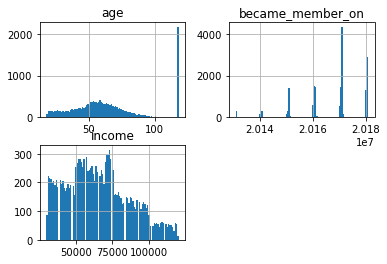

time: 2.16 s (started: 2021-10-25 20:03:11 +08:00)


In [49]:
profile.hist(bins=100)

In [50]:
profile[profile['age']>110].isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

time: 16 ms (started: 2021-10-25 20:03:13 +08:00)


In [51]:
(profile['age']>110).value_counts()

False    14825
True      2175
Name: age, dtype: int64

time: 16 ms (started: 2021-10-25 20:03:13 +08:00)


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

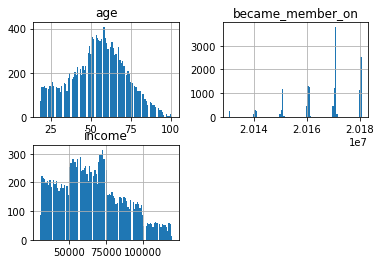

time: 1.53 s (started: 2021-10-25 20:03:13 +08:00)


In [52]:
## Histogram of profile without `age`==118
profile[profile['age']!=118].hist(bins=100)

Histogram of profile shows that the `age` has some abnormal values greater than 110. And `gender` and `income` of those consumers are null.

For we want to analyze the behavior of cusumers and the null ratio is not high (13%) and the null value is hard to impute based on `became_member_on`, we just mark those rows and impute.

When analyzing the data involving consumer attributes, we can choose the normal group. 

**handle gender**: impute gender na columns as 'O'


In [53]:
profile['gender'] = profile['gender'].fillna('O')
# transfer `gender` into dummoy columns
profile_gender_dummy = pd.get_dummies(profile['gender'],prefix='gender')
profile_gender_dummy.head()

,gender_F,gender_M,gender_O
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


time: 15 ms (started: 2021-10-25 20:03:15 +08:00)


**mark income**: mark na income as 1 and the other as 0

In [54]:
profile['is_income_na'] = profile['income'].isna()
profile['is_income_na'] = profile['is_income_na'].map(lambda x: 1 if x else 0)


time: 31 ms (started: 2021-10-25 20:03:15 +08:00)


**handle na values of `income` and `age`**:
1. map age 118 as np.nan for it can be some error
2. impute column `age` and `income` with median

In [55]:
profile['age']=profile['age'].map(lambda x:np.nan if x==118 else x)

time: 15 ms (started: 2021-10-25 20:03:15 +08:00)


In [56]:
# fill na
from sklearn.impute import SimpleImputer

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(profile[['age','income']])
profile[['age','income']] = imp_median.transform(profile[['age','income']])


time: 2.17 s (started: 2021-10-25 20:03:15 +08:00)


In [57]:
profile.head()

,gender,age,id,became_member_on,income,is_income_na
0,O,55.0,68be06ca386d4c31939f3a4f0e3dd783,20170212,64000.0,1
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0
2,O,55.0,38fe809add3b4fcf9315a9694bb96ff5,20180712,64000.0,1
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,0
4,O,55.0,a03223e636434f42ac4c3df47e8bac43,20170804,64000.0,1


time: 16 ms (started: 2021-10-25 20:03:17 +08:00)


In [58]:
# feature engeering base on became_member_on
profile['member_datetime'] = profile['became_member_on'].map(lambda x:parse(str(x)))
profile['member_date'] = profile['member_datetime'].dt.date


time: 1.31 s (started: 2021-10-25 20:03:17 +08:00)


In [59]:
profile['member_days_last'] = profile['member_date'].map(lambda x:date(2018,12,31)-x)
profile['member_days_last']  = profile['member_days_last'].dt.days

time: 125 ms (started: 2021-10-25 20:03:18 +08:00)


In [60]:
# handle member datetime
profile['member_in_year']=profile['member_datetime'].dt.year
profile['member_in_month']= profile['member_datetime'].dt.month
profile['member_on_day']= profile['member_datetime'].dt.day

time: 31 ms (started: 2021-10-25 20:03:19 +08:00)


In [61]:
profile = profile.merge(profile_gender_dummy,left_index=True,right_index=True)


time: 15 ms (started: 2021-10-25 20:03:19 +08:00)


In [62]:
# cut `income` into groups for EDA
cut_labels=range(30)
profile['income_cut'] =pd.cut(profile['income'], bins=30,labels=cut_labels)


time: 0 ns (started: 2021-10-25 20:03:19 +08:00)


In [63]:
# cut `member_days_last` into groups for EDA
cut_labels=range(30)
profile['member_days_cut'] =pd.cut(profile['member_days_last'], bins=30,labels=cut_labels)


time: 16 ms (started: 2021-10-25 20:03:19 +08:00)


In [64]:
profile_clean = profile.drop(['became_member_on','member_datetime','member_date'],axis=1)
profile_clean.head()

,gender,age,id,income,is_income_na,member_days_last,member_in_year,member_in_month,member_on_day,gender_F,gender_M,gender_O,income_cut,member_days_cut
0,O,55.0,68be06ca386d4c31939f3a4f0e3dd783,64000.0,1,687,2017,2,12,0,0,1,11,8
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,534,2017,7,15,1,0,0,27,6
2,O,55.0,38fe809add3b4fcf9315a9694bb96ff5,64000.0,1,172,2018,7,12,0,0,1,11,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,601,2017,5,9,1,0,0,23,7
4,O,55.0,a03223e636434f42ac4c3df47e8bac43,64000.0,1,514,2017,8,4,0,0,1,11,5


time: 16 ms (started: 2021-10-25 20:03:19 +08:00)


In [65]:
# save clean results
profile_clean.to_csv('profile_clean.csv')

time: 250 ms (started: 2021-10-25 20:03:19 +08:00)


# merge all

In [66]:
df_all = df_behavior.merge(profile_clean,left_on='person',right_on='id',how='left')

time: 110 ms (started: 2021-10-25 20:03:19 +08:00)


In [67]:
df_all.shape

(79444, 27)

time: 0 ns (started: 2021-10-25 20:03:19 +08:00)


In [68]:
df_all = df_all.merge(portfolio_clean,left_on='offer_id',right_on='id',how='left')

time: 110 ms (started: 2021-10-25 20:03:19 +08:00)


In [69]:
df_all.head()

,person,offer_id,offer_count,receive_count,view_count,promo_time_last,promo_count,promo_amount_sum,buy_time_last,buy_count,...,id_y,channel_email,channel_mobile,channel_social,channel_web,type_bogo,type_discount,type_informational,offer_code,return
0,0009655768c64bdeb2e877511632db8f,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,NaN,NaN,NaN,NaN,NaN,576.0,1.0,...,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0.0,1.0,0.0,aa5,0.199998
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0.0,0.0,1.0,bed,0.000000
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,1.0,0.0,0.0,0.0,1.0,837,0.000000
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,NaN,NaN,NaN,NaN,NaN,414.0,1.0,...,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0,20d,0.999980


time: 94 ms (started: 2021-10-25 20:03:19 +08:00)


In [70]:
df_clean=df_all.drop(['id_x','id_y'],axis=1)
df_clean.head()

,person,offer_id,offer_count,receive_count,view_count,promo_time_last,promo_count,promo_amount_sum,buy_time_last,buy_count,...,offer_type,channel_email,channel_mobile,channel_social,channel_web,type_bogo,type_discount,type_informational,offer_code,return
0,0009655768c64bdeb2e877511632db8f,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,NaN,NaN,NaN,NaN,NaN,576.0,1.0,...,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0,aa5,0.199998
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,informational,1.0,1.0,0.0,1.0,0.0,0.0,1.0,bed,0.000000
3,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0,837,0.000000
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,NaN,NaN,NaN,NaN,NaN,414.0,1.0,...,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0,20d,0.999980


time: 110 ms (started: 2021-10-25 20:03:19 +08:00)


In [71]:
show_desc(df_clean)

,buy_count,buy_time_last,buy_amount_sum,receive_count,other_count,other_amount_sum,promo_count,promo_time_last,promo_amount_sum,view_count,...,member_in_year,offer_id,member_in_month,income_cut,member_days_cut,member_on_day,age,income,member_days_last,person
null_count,70285,70285,70285,67870,63288,63288,58232,58232,58232,53298,...,0,0,0,0,0,0,0,0,0,0
null_ratio,0.884711,0.884711,0.884711,0.854312,0.796637,0.796637,0.732994,0.732994,0.732994,0.670888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dtypes,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,int64,object,int64,category,category,int64,float64,float64,int64,object
value_count,9159,9159,9159,11574,16156,16156,21212,21212,21212,26146,...,79444,79444,79444,79444,79444,79444,79444,79444,79444,79444
uique_counts,3,120,4100,4,31,11926,4,120,5905,5,...,6,11,12,30,30,31,84,91,1716,17000
value_min,1.0,0.0,0.39,1.0,1.0,0.05,1.0,0.0,0.15,1.0,...,2013,0,1,0,0,1,18.0,30000.0,158,0009655768c64bdeb2e877511632db8f
value_max,3.0,714.0,966.24,4.0,33.0,1179.56,4.0,714.0,1033.78,5.0,...,2018,fafdcd668e3743c1bb461111dcafc2a4,12,29,29,31,101.0,120000.0,1981,ffff82501cea40309d5fdd7edcca4a07
value_median,1.0,462.0,15.51,1.0,6.0,43.8,1.0,444.0,15.355,1.0,...,2017.0,NaN,7.0,NaN,NaN,16.0,55.0,64000.0,518.0,NaN


time: 656 ms (started: 2021-10-25 20:03:20 +08:00)


In [72]:
df_clean.to_csv('df_cleanR.csv')

time: 2.95 s (started: 2021-10-25 20:03:20 +08:00)
